This notebook serves to test generations of cellular automata of different forms, presently focusing on 1 dimensional automata.

The longer term intention is to train a neural network on outputs of automata with random inputs, and see if a network which can discriminate between automata types can be created. This might then be useful in testing the Quanta of Learning discussed in Tegmark's paper https://arxiv.org/pdf/2303.13506.pdf.

This network has been created below. Now, the intention is to understand the statistics of outputs to get an idea of how differentiated they actually are and which automata should be included in more sophisticted experiments By this I mean that some always return all 1s, some always return all 0s, and others generally overlap. These are uninteresting and should be removed. I do not yet understand such statistics.

In [1]:
# Importing necessary libraries

!pip install cellpylib

  Using cached cellpylib-2.4.0.tar.gz (38 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for cellpylib: filename=cellpylib-2.4.0-py3-none-any.whl size=37931 sha256=a391cf34049b44466e0be07b5b76ca06bbc990a54eebe201b321343c8e084720
  Stored in directory: c:\users\plogo\appdata\local\pip\cache\wheels\71\61\57\bbbbd5e8b79d6898242d075bd552bafab484034c3fcf710177
Successfully built cellpylib


In [2]:
# Importing necessary libraries

import cellpylib as cpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import seaborn as sns
import time

Epoch [1/1], Loss: 4.538077354431152
Accuracy on the train set: 2.25%
Accuracy on the test set: 3.0%


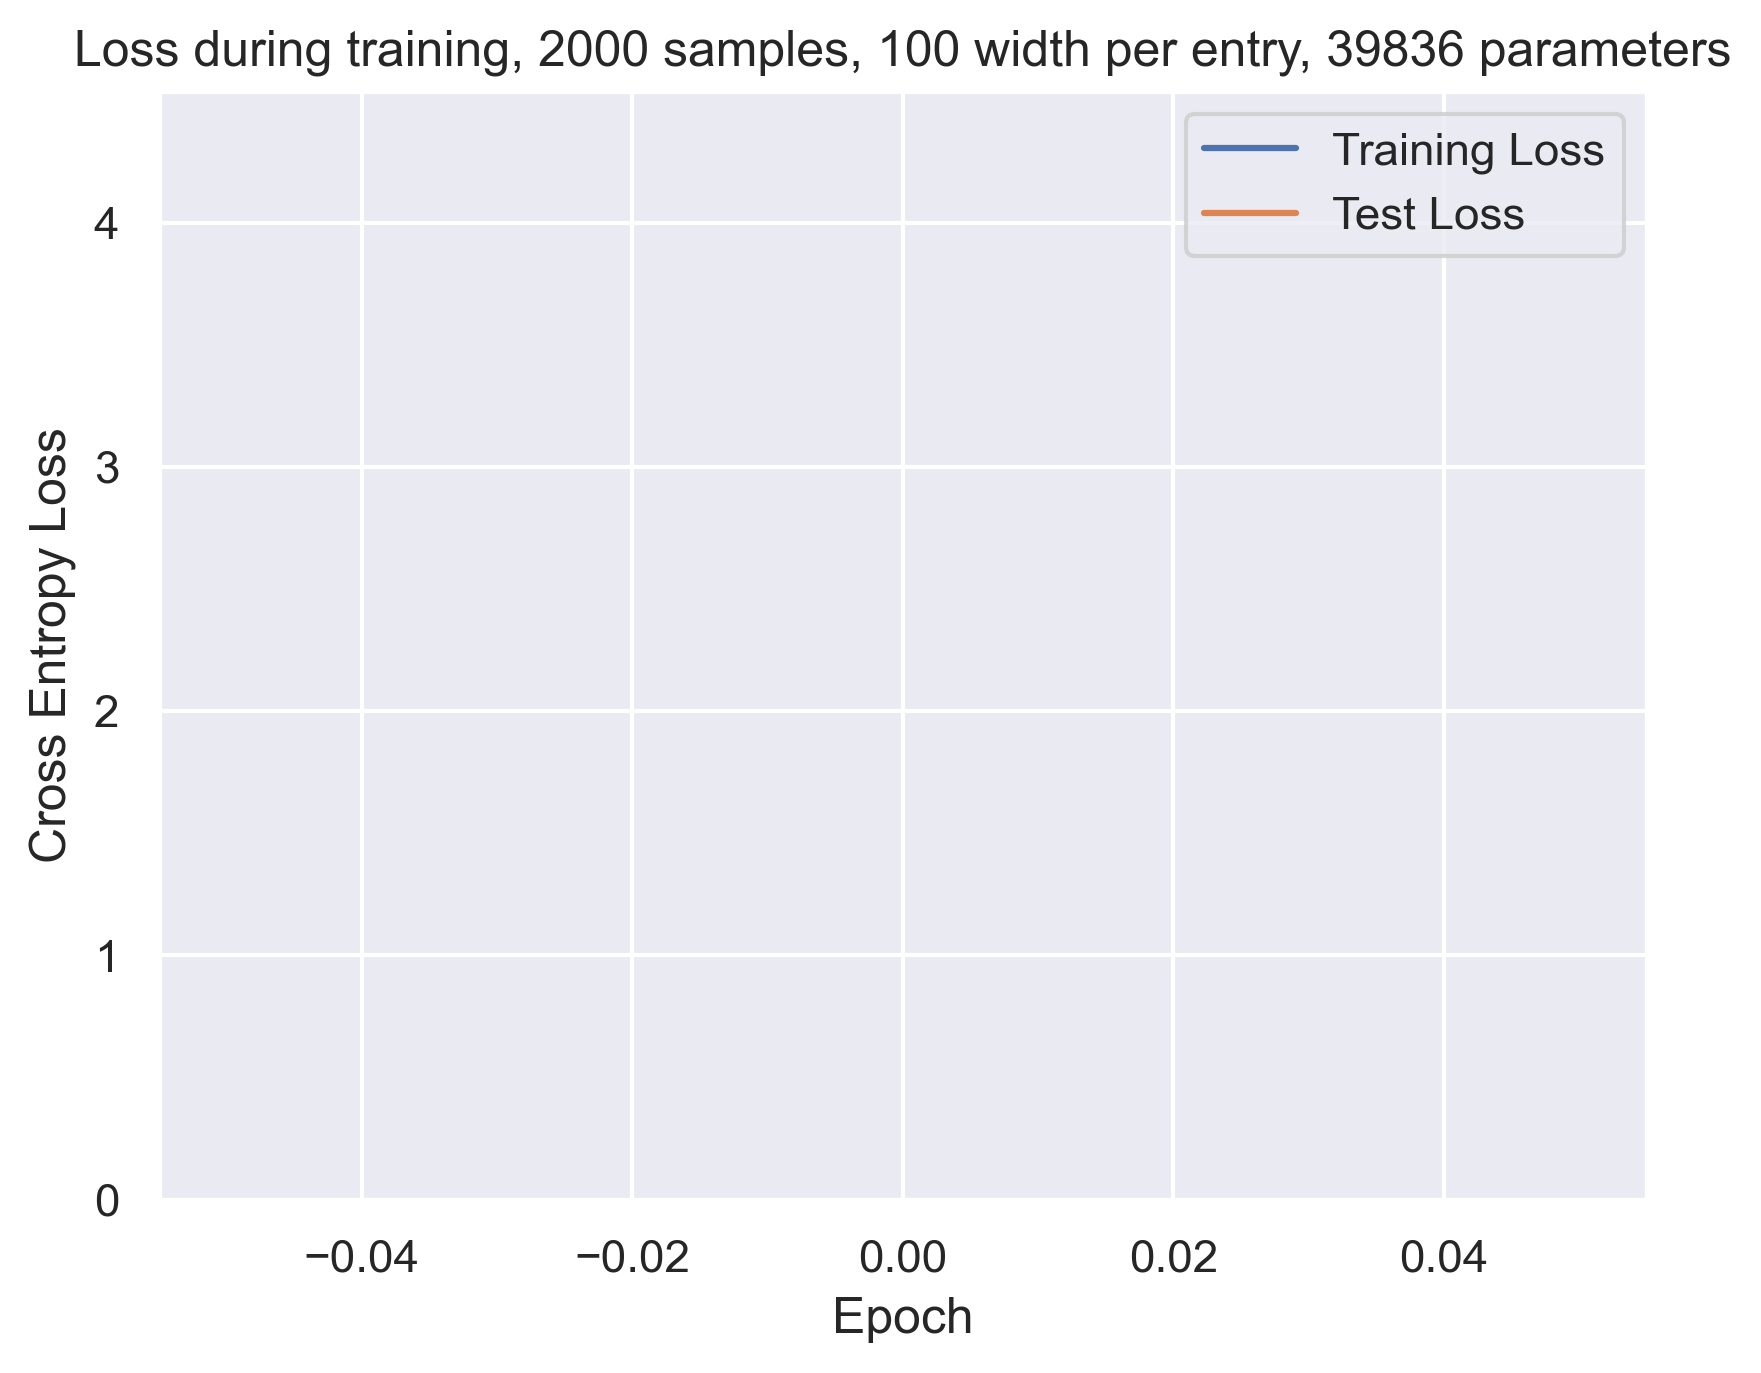

In [253]:
# This code is copied over from the google drive. Now with significant alterations

#@title Set System Parameters
data_size = 100 # the number of data points in each row of data
programmes_considered = np.arange(50,101,1) # the set of programmes being considered. For the 1D case it makes sense to consider all 0 to 255 programmes.
number_of_samples = 2000 # the number of random times the output of a programme will be calculated, given random inputs
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

#laterly used parameters
num_epochs = 1  # Number of training epochs
hidden_size = 256  # Update with the desired size of the hidden layer
learning_rate = 0.001 # learning rate used later in the optimizer
batch_size = 32 # Batch size used when creating the train and test datasets. Note that 5 is likely much too low, and 32 would be more suitable for this problem.
train_ratio = 0.8 # Specifies how much of the set will be used to training vs testing

#@title Model Initialisation
'''
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
'''
# Model Initialisation, WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
#hidden_size = 64  # Update with the desired size of the hidden layer
num_classes = len(programmes_considered)+1  # Number of potential classes

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

def create_data(data_size, programmes_considered, number_of_samples, timesteps):
  # creating data set, by randomly initialising number_of_samples times with random programmes.
  dataset = np.empty(shape=(number_of_samples, data_size), dtype=int) # each row is data_size length, with number_of_samples rows
  labels = np.empty(shape=(1, number_of_samples), dtype=int)
  #print(f"labels = ", labels)
  #print(dataset)
  for i in range(number_of_samples):

    #randomly selecting a rule number
    rule_number = np.random.choice(programmes_considered)
    #print(f"Considering rule_number = ", rule_number)
    cellular_automaton = cpl.init_random(data_size)
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
    #print(cellular_automaton[-1])
    dataset[i] = cellular_automaton[-1]
    labels[:,i] = rule_number

  return [dataset, labels]

def data_split(data):

  np.random.shuffle(data) #randomly select parts of the dataset
  #train_ratio = train_ratio # this reserves 80% for training, 20% for testing
  split_index = int(len(data) * train_ratio)

  train_data = data[:split_index]
  test_data = data[split_index:]
  #print(f"train_data = ", train_data)
  #print(f"test_data = ", test_data)

  # Separate the dataset and labels from the training and testing sets
  train_dataset, train_labels = zip(*train_data)
  test_dataset, test_labels = zip(*test_data)

  data_split = [train_dataset, train_labels, test_dataset, test_labels]
  return data_split

#@title Evaluating the train and test splits
[dataset, labels] = create_data(data_size, programmes_considered, number_of_samples, timesteps)
labels = labels[0]
# Shifting the labels such that they are indexed from 0. Required for cross entropy to work
labels = [x - min(labels) for x in labels]
data = [(data_sample, label) for data_sample, label in zip(dataset, labels)]
[train_dataset, train_labels, test_dataset, test_labels] = data_split(data)

#@title Setting up Training

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Prepare your dataset and data loaders (train_loader and test_loader)
# Create a TensorDataset from the train_dataset and train_labels
#dataset = torch.utils.data.TensorDataset([train_dataset, train_labels])
tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
tensor_test_dataset = TensorDataset(Tensor(test_dataset), Tensor(test_labels))

train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test_dataset, batch_size=batch_size, shuffle=True)
#print(f"train_loader = ", train_loader)

# Creating variables to track the change in error over time
training_loss = np.empty(num_epochs)
test_loss = np.empty(num_epochs)

# Training loop
#num_epochs = 100  # Number of training epochs
for epoch in range(num_epochs):
    for data, labels in train_loader:
        #print(f"data = ", data)
        #print(f"labels = ", labels)
        labels = labels.long() #required for the calculation of CrossEntropyLoss
        #print(f"labels = ", labels)
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # monitoring test loss during training
        for data, labels in test_loader:
            labels_test = labels.long()
            outputs_test = model(data)
            loss_test = criterion(outputs_test, labels_test)
            test_loss[epoch] = loss_test.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    if epoch%10==0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    training_loss[epoch] = loss.item()

# Evaluation on the training dataset (relevant for overparametrisation or otherwise deep learning systems)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in train_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the train set: {accuracy}%")

# Evaluation on the testing dataset
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy}%")

# Plotting the change in training loss as a function of epochs
epochs = np.arange(0,num_epochs, 1)

parameter_number = sum(p.numel() for p in model.parameters())

plt.plot(epochs, training_loss, test_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss during training, " + str(number_of_samples) + " samples, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
plt.ylim(bottom = 0)
plt.legend(["Training Loss", "Test Loss"])
plt.show()

In [ ]:
# Plotting test

epochs = np.arange(0,num_epochs, 1)

parameter_number = sum(p.numel() for p in model.parameters())

plt.plot(epochs, training_loss, test_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss during training, " + str(number_of_samples) + " samples, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
#plt.ylim(bottom = 0)
plt.legend(["Training Loss", "Test Loss"])
plt.show()

In [ ]:
# This cell is an area to visually experiment with the nature of cellular automaton
cellular_automaton = cpl.init_simple(100)
cellular_automaton = cpl.evolve(cellular_automaton, timesteps=150, memoize = True, apply_rule=lambda n, c, t: cpl.nks_rule(n, 5))
cpl.plot(cellular_automaton)
print(cellular_automaton[-1])

C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\py39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


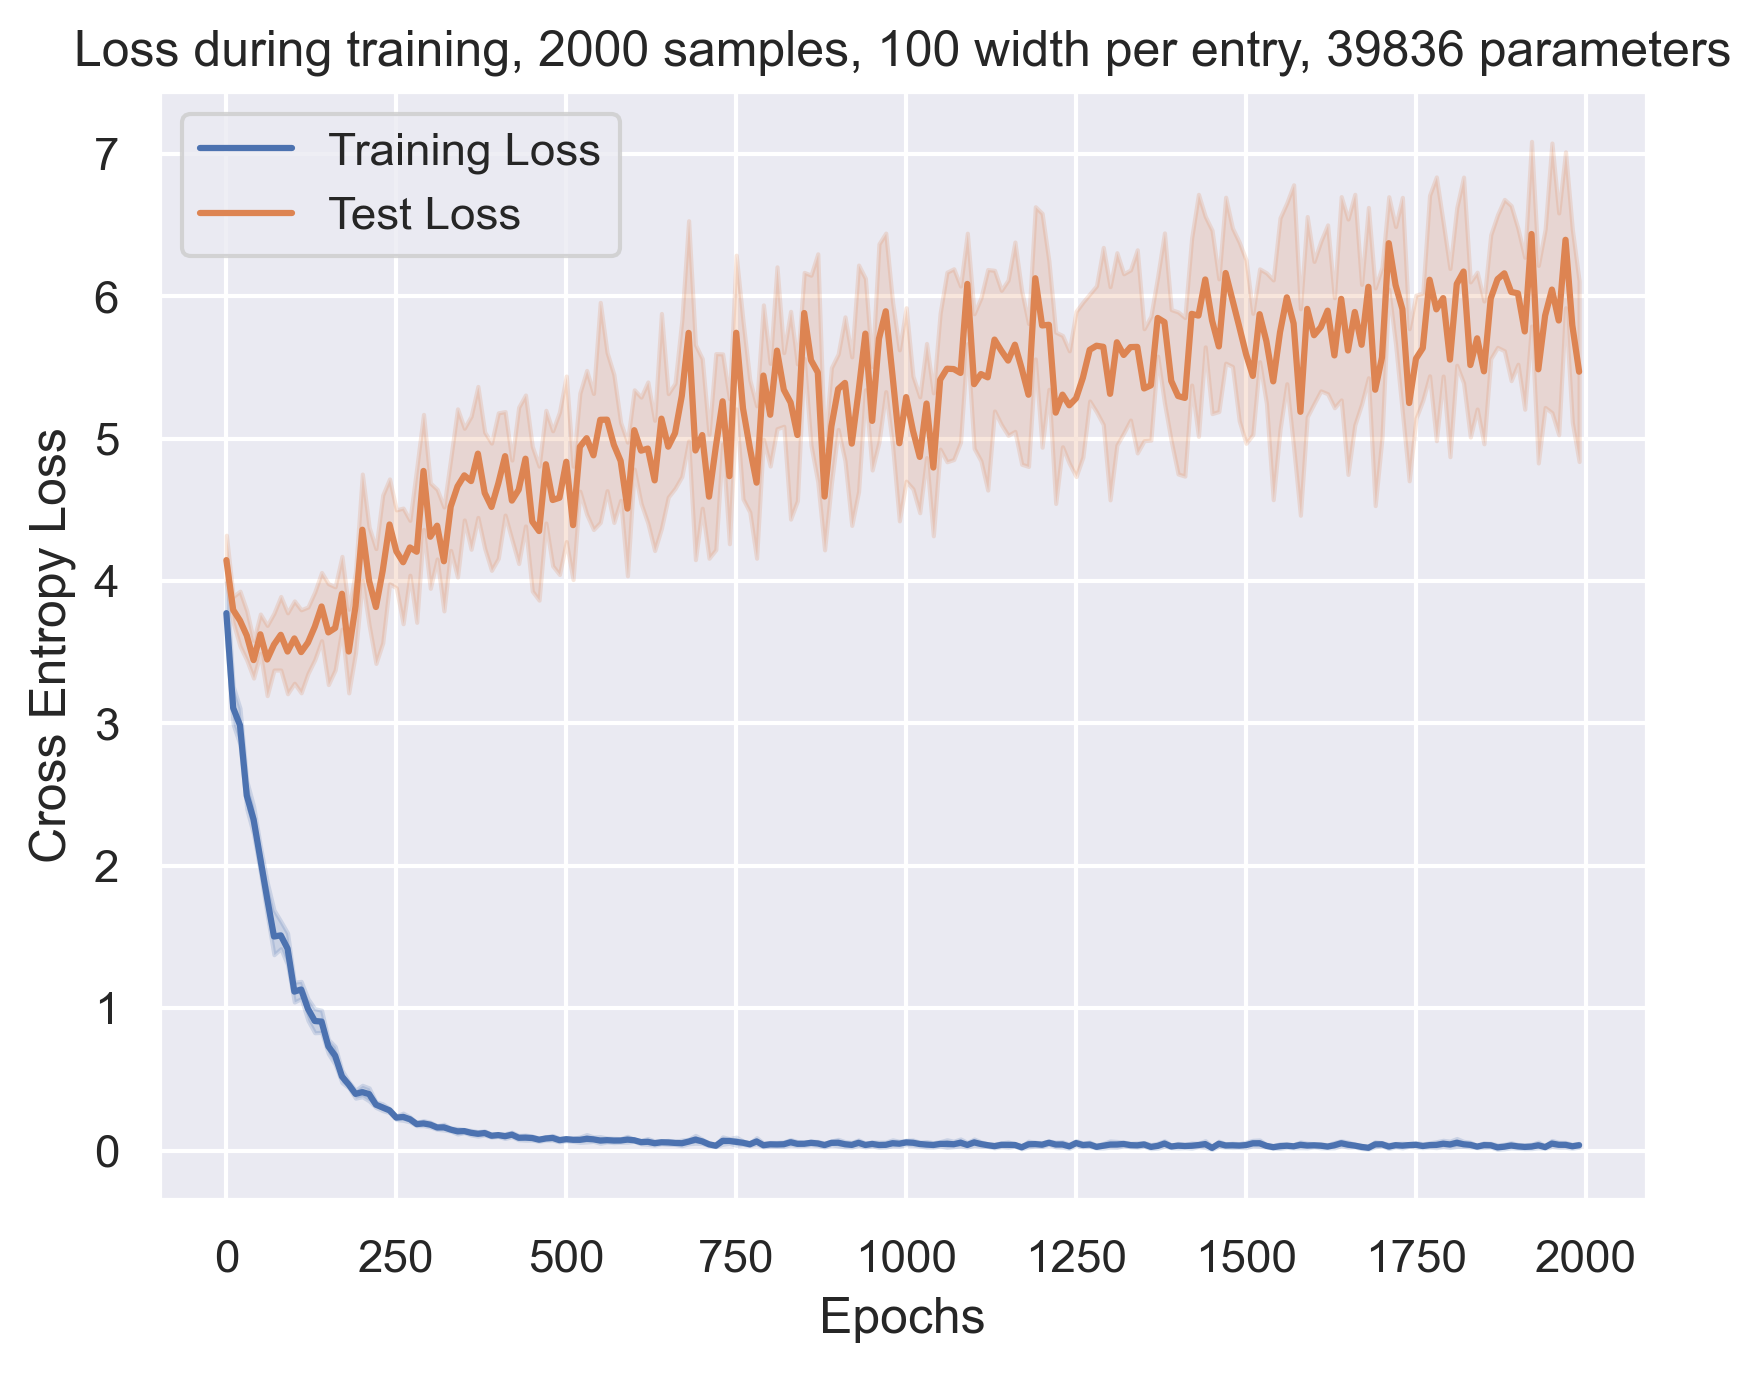

In [255]:
# Plotting test with seaborn, to better interpret very high variance training runs

# Redefining epochs here, in case it is not carried over from previous cells. Likely unneccesary
epochs = np.arange(0, num_epochs, 1)

parameter_number = sum(p.numel() for p in model.parameters())

# Taking values from nearby epochs and averaging
moving_avg = 10 # The size of the averaging window being used.
reshaped_training_loss = np.reshape(training_loss, (-1, moving_avg)) #note that if the length of training_loss is not divisible by 10, the final elements are ignored
reshaped_test_loss = np.reshape(test_loss, (-1, moving_avg))
reshaped_epochs = np.reshape(epochs, (-1, moving_avg))
filtered_epochs = reshaped_epochs[:,0]
repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)

pandas_df = pd.DataFrame({'Training Loss': reshaped_training_loss.flatten(), 'Test Loss': reshaped_test_loss.flatten(), 'Epochs': repeated_filtered_epochs})
pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = ['Training Loss', 'Test Loss'], var_name='line', value_name = 'Values')


sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title("Loss during training, " + str(number_of_samples) + " samples, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
plt.legend(loc='best')
plt.rcParams['figure.dpi'] = 300
plt.show()


In [228]:
# Creating data in an individual cell, to be passed on to a network later.
# Note that most of the code here is copied from other cells, and the parameters need to be the same for this to work
# This cell also produces the necessary splits into train and test data, such that randomisation is removed from the neural network cells

# For the data generation process, the following parameters must be set
data_size = 100 # the number of data points in each row of data
programmes_considered = np.arange(30,51,1) # the set of programmes being considered. For the 1D case it makes sense to consider all 0 to 255 programmes.
number_of_samples = 500 # the number of random times the output of a programme will be calculated, given random inputs
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

def create_data(data_size, programmes_considered, number_of_samples, timesteps):
  # creating data set, by randomly initialising number_of_samples times with random programmes.
  dataset = np.empty(shape=(number_of_samples, data_size), dtype=int) # each row is data_size length, with number_of_samples rows
  labels = np.empty(shape=(1, number_of_samples), dtype=int)
  #print(f"labels = ", labels)
  #print(dataset)
  for i in range(number_of_samples):

    #randomly selecting a rule number
    rule_number = np.random.choice(programmes_considered)
    #print(f"Considering rule_number = ", rule_number)
    cellular_automaton = cpl.init_random(data_size)
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
    #print(cellular_automaton[-1])
    dataset[i] = cellular_automaton[-1]
    labels[:,i] = rule_number

    if i%100 == 0:
        print(f"Number of samples = ", i)

  return [dataset, labels]

def data_split(data):

  np.random.shuffle(data) #randomly select parts of the dataset
  #train_ratio = train_ratio # this reserves 80% for training, 20% for testing
  split_index = int(len(data) * train_ratio)

  train_data = data[:split_index]
  test_data = data[split_index:]
  #print(f"train_data = ", train_data)
  #print(f"test_data = ", test_data)

  # Separate the dataset and labels from the training and testing sets
  train_dataset, train_labels = zip(*train_data)
  test_dataset, test_labels = zip(*test_data)

  data_split = [train_dataset, train_labels, test_dataset, test_labels]
  return data_split

#@title Evaluating the train and test splits
[dataset, labels] = create_data(data_size, programmes_considered, number_of_samples, timesteps)
labels = labels[0]
# Shifting the labels such that they are indexed from 0. Required for cross entropy to work
labels = [x - min(labels) for x in labels]
data = [(data_sample, label) for data_sample, label in zip(dataset, labels)]
[train_dataset, train_labels, test_dataset, test_labels] = data_split(data)

# Prepare your dataset and data loaders (train_loader and test_loader)
# Create a TensorDataset from the train_dataset and train_labels
#dataset = torch.utils.data.TensorDataset([train_dataset, train_labels])
tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
tensor_test_dataset = TensorDataset(Tensor(test_dataset), Tensor(test_labels))

train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test_dataset, batch_size=batch_size, shuffle=True)
#print(f"train_loader = ", train_loader)

Number of samples =  0
Number of samples =  100
Number of samples =  200
Number of samples =  300
Number of samples =  400


In [ ]:
# This cell only does the training portion of the analysis. All data must have already been created before this cell is used
# This is to allow faster running of experiments when the data creation is the majority of computational time
# Note that this cell also does the accuracy evaluation (and of course monitors training and test loss), but does not make any plots
# This cell also has time measurement capabilities. I may want to extend this across the rest of the code I'm not sure.

# At this stage, it is safe to modify the following parameters, as they are not relevant to the data creation process / compatabilities
num_epochs = 1000  # Number of training epochs
hidden_size = 256  # Update with the desired size of the hidden layer
learning_rate = 0.001 # learning rate used later in the optimizer
batch_size = 32 # Batch size used when creating the train and test datasets. Note that 5 is likely much too low, and 32 would be more suitable for this problem.
train_ratio = 0.8 # Specifies how much of the set will be used to training vs testing

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
num_classes = len(programmes_considered)  # Number of potential classes

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)


# Creating variables to track the change in error over time
training_loss = np.empty(num_epochs)
test_loss = np.empty(num_epochs)

time_list = np.empty(num_epochs)

# Training loop
#num_epochs = 100  # Number of training epochs
for epoch in range(num_epochs):
    start = time.time()
    for data, labels in train_loader:
        #print(f"data = ", data)
        #print(f"labels = ", labels)
        labels = labels.long() #required for the calculation of CrossEntropyLoss
        #print(f"labels = ", labels)
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # monitoring test loss during training
        for data, labels in test_loader:
            labels_test = labels.long()
            outputs_test = model(data)
            loss_test = criterion(outputs_test, labels_test)
            test_loss[epoch] = loss_test.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Comprehension of time taken
    end = time.time()
    time_difference = end - start
    time_list[epoch] = time_difference

    # Print the loss after every 10th epoch
    if epoch%10==0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Time: {time_difference}")
    training_loss[epoch] = loss.item()

# Evaluation on the training dataset (relevant for overparametrisation or otherwise deep learning systems)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in train_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the train set: {accuracy}%")

# Evaluation on the testing dataset
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy}%")

In [ ]:
# Print model parameters

for name, param in model.named_parameters():
    print(f"Parameter: {name}")
    print(f"Shape: {param.shape}")
    print(f"Initial Values:\n{param.data}")
    print()

In [237]:
# Create a model test

data_size = 100 # the number of data points in each row of data
programmes_considered = np.arange(0,256,1) # the set of programmes being considered. For the 1D case it makes sense to consider all 0 to 255 programmes.
hidden_size = 256

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
num_classes = len(programmes_considered)  # Number of potential classes

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)

parameter_number = sum(p.numel() for p in model.parameters())

print(f"Parameter number: ", parameter_number)

Parameter number:  117248


In [ ]:
# Desparate model test

#laterly used parameters
num_epochs = 2000  # Number of training epochs
hidden_size = 256  # Update with the desired size of the hidden layer
learning_rate = 0.001 # learning rate used later in the optimizer
batch_size = 32 # Batch size used when creating the train and test datasets. Note that 5 is likely much too low, and 32 would be more suitable for this problem.
train_ratio = 0.8 # Specifies how much of the set will be used to training vs testing
'''
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
    
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the input size, hidden size, and number of classes
input_size = data_size  # Update with the actual input size
#hidden_size = 64  # Update with the desired size of the hidden layer
num_classes = len(programmes_considered)+1  # Number of potential classes

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size, num_classes)
'''

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


# Creating variables to track the change in error over time
training_loss = np.empty(num_epochs)
test_loss = np.empty(num_epochs)

# Training loop
#num_epochs = 100  # Number of training epochs
for epoch in range(num_epochs):
    for data, labels in train_loader:
        #print(f"data = ", data)
        #print(f"labels = ", labels)
        labels = labels.long() #required for the calculation of CrossEntropyLoss
        #print(f"labels = ", labels)
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)

        # monitoring test loss during training
        for data, labels in test_loader:
            labels_test = labels.long()
            outputs_test = model(data)
            loss_test = criterion(outputs_test, labels_test)
            test_loss[epoch] = loss_test.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss after each epoch
    #if epoch%10==0:
    #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}, Test Loss: {loss_test.item()}")
    training_loss[epoch] = loss.item()

# Evaluation on the training dataset (relevant for overparametrisation or otherwise deep learning systems)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in train_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the train set: {accuracy}%")

# Evaluation on the testing dataset
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy}%")

# Plotting the change in training loss as a function of epochs
epochs = np.arange(0,num_epochs, 1)

parameter_number = sum(p.numel() for p in model.parameters())

plt.plot(epochs, training_loss, test_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss during training, " + str(number_of_samples) + " samples, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
plt.ylim(bottom = 0)
plt.legend(["Training Loss", "Test Loss"])
plt.show()

# Beyond this point are more recent edits made to create plots

In [3]:
# Functions (by themselves)

# Model Initialisation, WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.bn2(out)
        return out

def create_data(data_size, programmes_considered, number_of_samples, timesteps):
  # creating data set, by randomly initialising number_of_samples times with random programmes.
  dataset = np.empty(shape=(number_of_samples, data_size), dtype=int) # each row is data_size length, with number_of_samples rows
  labels = np.empty(shape=(1, number_of_samples), dtype=int)
  #print(f"labels = ", labels)
  #print(dataset)
  for i in range(number_of_samples):

    #randomly selecting a rule number
    rule_number = np.random.choice(programmes_considered)
    #print(f"Considering rule_number = ", rule_number)
    cellular_automaton = cpl.init_random(data_size)
    cellular_automaton = cpl.evolve(cellular_automaton, timesteps=timesteps, memoize=True, apply_rule=lambda n, c, t: cpl.nks_rule(n, rule_number))
    #print(cellular_automaton[-1])
    dataset[i] = cellular_automaton[-1]
    labels[:,i] = rule_number

  return [dataset, labels]

def data_split(data):

  np.random.shuffle(data) #randomly select parts of the dataset
  #train_ratio = train_ratio # this reserves 80% for training, 20% for testing
  split_index = int(len(data) * train_ratio)

  train_data = data[:split_index]
  test_data = data[split_index:]
  #print(f"train_data = ", train_data)
  #print(f"test_data = ", test_data)

  # Separate the dataset and labels from the training and testing sets
  train_dataset, train_labels = zip(*train_data)
  test_dataset, test_labels = zip(*test_data)

  data_split = [train_dataset, train_labels, test_dataset, test_labels]
  return data_split

100%|██████████| 300/300 [1:25:57<00:00, 17.19s/it]    


Accuracy on the train set: 82.1533203125%
Accuracy on the test set: 3.3203125%


100%|██████████| 300/300 [50:04<00:00, 10.02s/it]  


Accuracy on the train set: 80.9326171875%
Accuracy on the test set: 4.58984375%


100%|██████████| 300/300 [52:35<00:00, 10.52s/it]


Accuracy on the train set: 82.3486328125%
Accuracy on the test set: 4.4921875%


MemoryError: Unable to allocate 1.95 MiB for an array with shape (5120, 100) and data type int32

Error in callback <function _draw_all_if_interactive at 0x0000017D8D1AE5C0> (for post_execute), with arguments args (),kwargs {}:


MemoryError: In RendererAgg: Out of memory

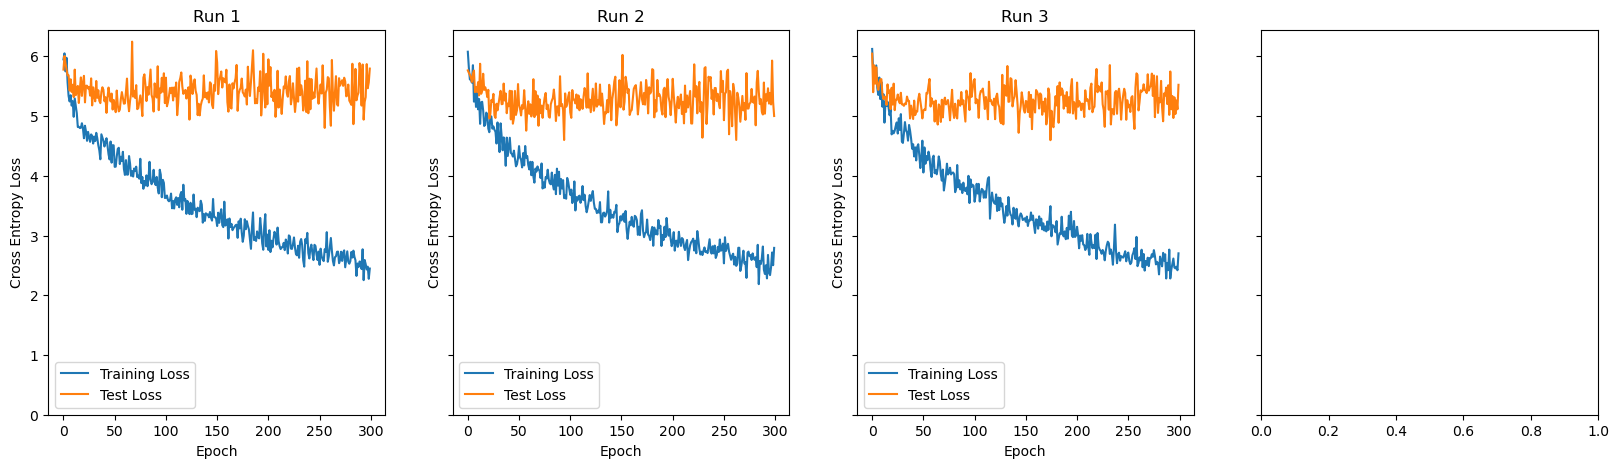

In [11]:
# This code is copied over from the google drive. Now with significant alterations
from tqdm import tqdm
#@title Set System Parameters
data_size = 100 # the number of data points in each row of data
programmes_considered = np.arange(0,256,1) # the set of programmes being considered. For the 1D case it makes sense to consider all 0 to 255 programmes.
number_of_samples = 2560*2 # the number of random times the output of a programme will be calculated, given random inputs
timesteps = 100 # the number of timesteps which each programme is run for before the output is used to train the model

#laterly used parameters
num_epochs = 300  # Number of training epochs
hidden_size = 256  # Update with the desired size of the hidden layer
learning_rate = 0.001 # learning rate used later in the optimizer
batch_size = 32 # Batch size used when creating the train and test datasets. Note that 5 is likely much too low, and 32 would be more suitable for this problem.
train_ratio = 0.8 # Specifies how much of the set will be used to training vs testing

num_repeats = 4

fig, axs = plt.subplots(1, num_repeats, figsize=(5 * num_repeats, 5), sharey=True)

for repeat_idx in range(num_repeats):
    
    # Define the input size, hidden size, and number of classes
    input_size = data_size  # Update with the actual input size
    #hidden_size = 64  # Update with the desired size of the hidden layer
    num_classes = len(programmes_considered)+1  # Number of potential classes
    
    # Create an instance of the neural network
    model = NeuralNetwork(input_size, hidden_size, num_classes)
    
    #@title Evaluating the train and test splits
    [dataset, labels] = create_data(data_size, programmes_considered, number_of_samples, timesteps)
    labels = labels[0]
    # Shifting the labels such that they are indexed from 0. Required for cross entropy to work
    labels = [x - min(labels) for x in labels]
    data = [(data_sample, label) for data_sample, label in zip(dataset, labels)]
    [train_dataset, train_labels, test_dataset, test_labels] = data_split(data)
    
    #@title Setting up Training
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Prepare your dataset and data loaders (train_loader and test_loader)
    # Create a TensorDataset from the train_dataset and train_labels
    #dataset = torch.utils.data.TensorDataset([train_dataset, train_labels])
    tensor_train_dataset = TensorDataset(Tensor(train_dataset), Tensor(train_labels))
    tensor_test_dataset = TensorDataset(Tensor(test_dataset), Tensor(test_labels))
    
    train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(tensor_test_dataset, batch_size=batch_size, shuffle=True)
    #print(f"train_loader = ", train_loader)
    
    # Creating variables to track the change in error over time
    training_loss = np.empty(num_epochs)
    test_loss = np.empty(num_epochs)
    
    # Training loop
    #num_epochs = 100  # Number of training epochs
    for epoch in tqdm(range(num_epochs)):
        for data, labels in train_loader:
            #print(f"data = ", data)
            #print(f"labels = ", labels)
            labels = labels.long() #required for the calculation of CrossEntropyLoss
            #print(f"labels = ", labels)
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
    
            # monitoring test loss during training
            for data, labels in test_loader:
                labels_test = labels.long()
                outputs_test = model(data)
                loss_test = criterion(outputs_test, labels_test)
                test_loss[epoch] = loss_test.item()
    
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # Print the loss after each epoch
        #if epoch%10==0:
        #    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
        training_loss[epoch] = loss.item()
    
    # Evaluation on the training dataset (relevant for overparametrisation or otherwise deep learning systems)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in train_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        accuracy = 100 * correct / total
        print(f"Accuracy on the train set: {accuracy}%")
    
    # Evaluation on the testing dataset
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
        accuracy = 100 * correct / total
        print(f"Accuracy on the test set: {accuracy}%")
    
    parameter_number = sum(p.numel() for p in model.parameters())
    epochs = np.arange(0, num_epochs, 1)
    axs[repeat_idx].plot(epochs, training_loss, test_loss)
    axs[repeat_idx].set_xlabel("Epoch")
    axs[repeat_idx].set_ylabel("Cross Entropy Loss")
    axs[repeat_idx].title.set_text(f"Run {repeat_idx+1}")
    axs[repeat_idx].set_ylim(bottom = 0)
    axs[repeat_idx].legend(["Training Loss", "Test Loss"])

#plt.tight_layout()
plt.suptitle(f'Model Performance')
# Show the subplots
plt.show()


'''
    # Redefining epochs here, in case it is not carried over from previous cells. Likely unneccesary
    epochs = np.arange(0, num_epochs, 1)
    
    parameter_number = sum(p.numel() for p in model.parameters())
    
    # Taking values from nearby epochs and averaging
    moving_avg = 10 # The size of the averaging window being used.
    reshaped_training_loss = np.reshape(training_loss, (-1, moving_avg)) #note that if the length of training_loss is not divisible by 10, the final elements are ignored
    reshaped_test_loss = np.reshape(test_loss, (-1, moving_avg))
    reshaped_epochs = np.reshape(epochs, (-1, moving_avg))
    filtered_epochs = reshaped_epochs[:,0]
    repeated_filtered_epochs = np.repeat(filtered_epochs, moving_avg)
    
    pandas_df = pd.DataFrame({'Training Loss': reshaped_training_loss.flatten(), 'Test Loss': reshaped_test_loss.flatten(), 'Epochs': repeated_filtered_epochs})
    pandas_df_melted = pd.melt(pandas_df, id_vars = 'Epochs', value_vars = ['Training Loss', 'Test Loss'], var_name='line', value_name = 'Values')
    
    
    sns.lineplot(data=pandas_df_melted, x='Epochs', y='Values', hue='line')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.title("Loss during training, " + str(number_of_samples) + " samples, " + str(data_size) + " width per entry, " + str(parameter_number) + " parameters")
    plt.legend(loc='best')
    plt.rcParams['figure.dpi'] = 300
    plt.show()
'''

In [12]:
plt.savefig('Cellular Automata NN runs.png')

<Figure size 640x480 with 0 Axes>